<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [97]:
!python --version

Python 3.10.9


In [98]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/test/ccer/abt_100.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/test/ccer/buy_100.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/test/ccer/gt_100.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block Building

In [99]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [100]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/200 [00:00<?, ?it/s]

In [101]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0159 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      1.78% 
	Recall:       100.00%
	F1-score:       3.51%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 49
	False positives: 2697
	True negatives: 7303
	False negatives: 0
	Total comparisons: 2746
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 1.7844136926438456,
 'Recall %': 100.0,
 'F1 %': 3.5062611806797856,
 'True Positives': 49,
 'False Positives': 2697,
 'True Negatives': 7303,
 'False Negatives': 0}

# Block Cleaning

In [102]:
from pyjedai.block_cleaning import BlockFiltering

In [103]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [104]:
from pyjedai.block_cleaning import BlockPurging

In [105]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/372 [00:00<?, ?it/s]

In [106]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 25.0
Runtime: 0.0078 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      6.06% 
	Recall:        87.76%
	F1-score:      11.35%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 43
	False positives: 666
	True negatives: 9328
	False negatives: 6
	Total comparisons: 709
────────────────────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 6.064880112834979,
 'Recall %': 87.75510204081633,
 'F1 %': 11.345646437994723,
 'True Positives': 43,
 'False Positives': 666,
 'True Negatives': 9328,
 'False Negatives': 6}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [107]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM
)

In [108]:
%%time
LTPM = LocalTopPM(
    budget = 1000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = LTPM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 19 ms, sys: 68 µs, total: 19 ms
Wall time: 19 ms


In [109]:
%%time
GTPM = GlobalTopPM(
    budget = 1000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = GTPM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 9.08 ms, sys: 25 µs, total: 9.1 ms
Wall time: 9.08 ms


In [110]:
%%time
GPSNM = GlobalPSNM(
    budget = 1000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = GPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 13 ms


In [111]:
%%time
LPSNM = LocalPSNM(
    budget = 1000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = LPSNM.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 5.7 ms, sys: 40 µs, total: 5.74 ms
Wall time: 5.72 ms


In [119]:
%%time
ENNBPM = EmbeddingsNNBPM(
    budget = 1000,
    vectorizer = 'roberta',
    similarity_search = 'faiss',
    emission= 'avg',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ENNBPM.predict(cleaned_blocks, data, tqdm_disable=True)

Embeddings-NN Block Building [roberta, faiss]:   0%|          | 0/200 [00:00<?, ?it/s]

Device selected:  cpu
Loading embeddings from file...
Loading file:  .embeddings/d1_1.npy
Embeddings not found. Creating new ones.


ValueError: Embeddings not found.

In [113]:
%%time
rpm = RandomPM(
    budget = 1000,
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 866 µs, sys: 21 µs, total: 887 µs
Wall time: 890 µs


In [114]:
%%time
pesm = PESM(
    budget = 1000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 36.8 ms, sys: 0 ns, total: 36.8 ms
Wall time: 36.5 ms


In [115]:
def reverse(id1, id2):
    if(id1 > id2):
        return (id2, id1)
    else:
        return (id1, id2)

def get_duplicates(tuple_list):
    count = 0
    seen_pairs = set()
    duplicates = []
    
    for item in tuple_list:
        weight, id1, id2 = item
        pair = reverse(id1, id2)
        
        if pair in seen_pairs:
            dupl.append(pair)
        else:
            seen_pairs.add(pair)
    
    return duplicates

In [116]:
# some progressive methods don't allow for comparison storage within graph
# it changes the order of the emitted pairs
methods_prediction_data = []

# ltpm_pairs_graph.edges = sorted(ltpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
# gtpm_pairs_graph.edges = sorted(gtpm_pairs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# ltpm_pairs_graph.edges = [edge[:2] for edge in ltpm_pairs_graph.edges]
# gtpm_pairs_graph.edges = [edge[:2] for edge in gtpm_pairs_graph.edges]


# ltpm_pairs_graph
# gtpm_pairs_graph
# rpm_pairs_graph
# gpsnm_pairs_graph
# lpsnm_pairs_graph
# pesm_pairs_graph

methods_prediction_data.append(("Random", [edge for edge in rpm_pairs_graph.edges]))
methods_prediction_data.append(("Local Top", [edge[:2] for edge in ltpm_pairs_graph.edges]))
methods_prediction_data.append(("Global Top", [edge[:2] for edge in gtpm_pairs_graph.edges]))
methods_prediction_data.append(("GSN", gpsnm_pairs_graph))
methods_prediction_data.append(("LSN", lpsnm_pairs_graph))
methods_prediction_data.append(("ES", pesm_pairs_graph))


# methods_prediction_data.append(("Random", list([edge[:2] for edge in rpm_pairs_graph.edges])))
# methods_prediction_data.append(("Entity Esch", list(edge[1:] for edge in pesm_pairs_graph)))
# methods_prediction_data.append(("Global Sorted Neighborhood", gpsnm_pairs_graph))
# methods_prediction_data.append(("Local Sorted Neighborhood", lpsnm_pairs_graph))
# methods_prediction_data.append(("Embedding BNN", list(ennbpm_pairs_graph)))

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '80': 80, '81': 81, '82': 82, '83': 83, '84': 84, '85': 85, '86': 86, '87': 87, '88': 88, '89': 89, '90': 90, '91': 91, '92': 92, '93': 93, '94': 94, '95': 95, '96': 96, '97': 97, '98': 98, '99': 99}
{'0': 100, '1': 101

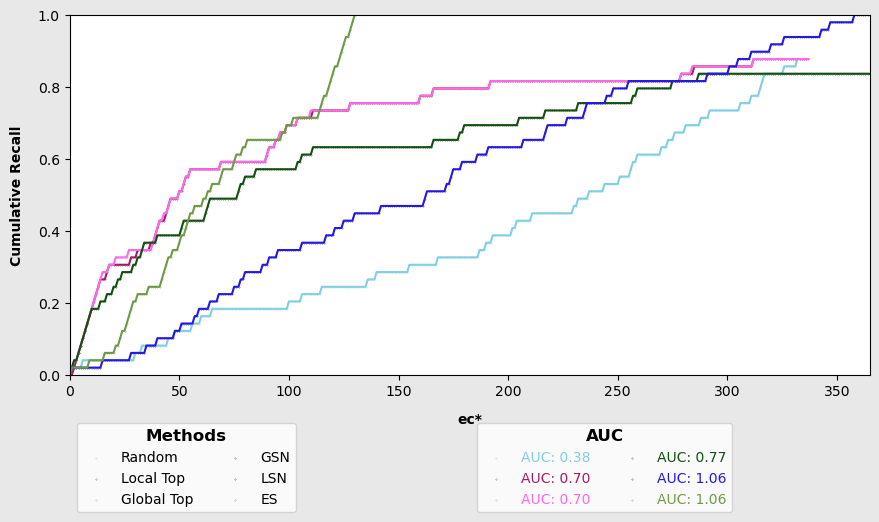

CPU times: user 262 ms, sys: 8.05 ms, total: 270 ms
Wall time: 309 ms


In [117]:
%%time
GPSNM.evaluate_auc_roc(methods_prediction_data = methods_prediction_data, proportional = False)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [ ]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
ccc.evaluate(clusters, with_classification_report=True)

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [ ]:
umc.evaluate(clusters, with_classification_report=True)